In [111]:
# Can be applied to any of the world bank datasets
# Applying to all by first merging

In [112]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import sys

In [113]:
# Pull all raw WorldBankData across all indicators

folder_path = "../WorldBankDatasets/"

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Initialize the merged DataFrame with the first DataFrame
merged_df = dataframes[0]

# Merge the remaining DataFrames iteratively
for df in dataframes[1:]:
    merged_df = merged_df.merge(df, on=["Country", "Year"], how="outer")


# Drop columns that end with '_y' - artifact of the merge
columns_to_drop = [col for col in merged_df.columns if col.endswith("_y")]
merged_df = merged_df.drop(columns=columns_to_drop)

# Remove the _x suffix from column names to clean things up
merged_df.columns = [col.rstrip("_x") for col in merged_df.columns]

# Keep only the first occurrence of each column name
unique_columns = ~merged_df.columns.duplicated(keep="first")
merged_df = merged_df.loc[:, unique_columns]

merged_df

,Country,Year,2.0.cov.FPS,2.0.hoi.FPS,BAR.NOED.1519.FE.ZS,BAR.NOED.1519.ZS,BAR.NOED.15UP.FE.ZS,BAR.NOED.15UP.ZS,BAR.NOED.2024.FE.ZS,BAR.NOED.2024.ZS,...,TX.VAL.TECH.MF.ZS,SL.TLF.0714.SW.ZS,SL.TLF.0714.WK.ZS,SL.TLF.0714.ZS,SL.TLF.ACTI.1524.FE.ZS,SL.TLF.ACTI.1524.MA.ZS,SL.TLF.ACTI.1524.ZS,SL.TLF.ACTI.FE.ZS,SL.TLF.ACTI.MA.ZS,SL.TLF.ACTI.ZS
0,AUS,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AUS,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUS,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AUS,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUS,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3313,USA,2080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3314,USA,2085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3315,USA,2090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3316,USA,2095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


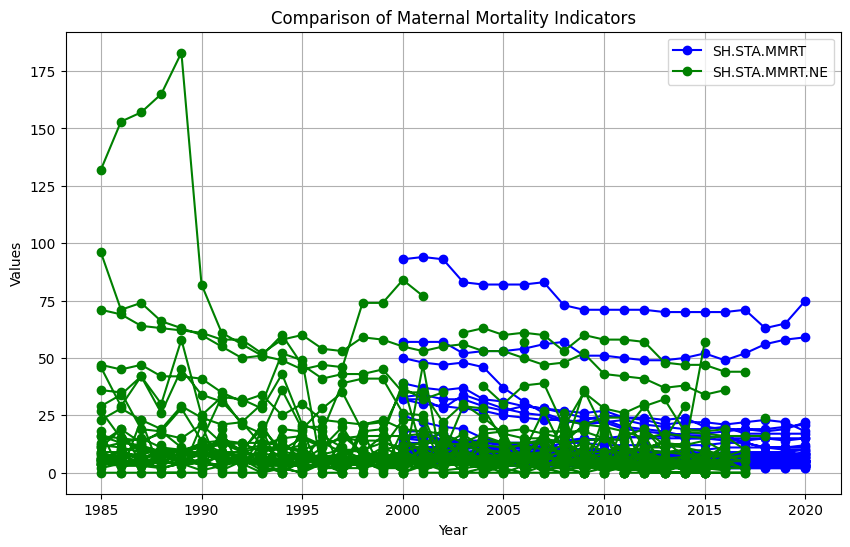

In [114]:
# Extract the 'Year' and Maternal Mortality Rate columns for comparison
years = merged_df["Year"]
column1 = merged_df["SH.STA.MMRT"]
column2 = merged_df["SH.STA.MMRT.NE"]


# Create a line plot for each column
plt.figure(figsize=(10, 6))
plt.plot(years, column1, label="SH.STA.MMRT", marker="o", linestyle="-", color="b")
plt.plot(years, column2, label="SH.STA.MMRT.NE", marker="o", linestyle="-", color="g")


# Add labels
plt.title("Comparison of Maternal Mortality Indicators")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

#### The same indicator across World Bank topics are consistent but the 2 maternal mortality rate indicators vary largely  

Code	SH.STA.MMRT.NE
Indicator Name	Maternal mortality ratio (national estimate, per 100,000 live births)   

Code	SH.STA.MMRT
Indicator Name	Maternal mortality ratio (modeled estimate, per 100,000 live births)

In [115]:
# first all rows without a value for maternal health should be dropped.
# merged_df = merged_df.dropna(subset=['SH.STA.MMRT'])
# merged_df


#### Moving this into the modeling notebooks as both maternal mortality predictors should be explored

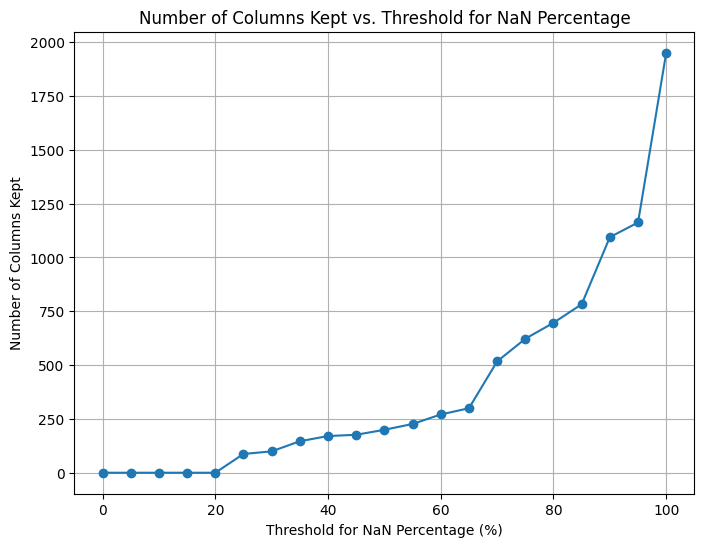

In [116]:
# let's drop columns where the number of NaN's is greater than a given threshold %
# First determine what that threshold should be

# Range of thresholds to test
thresholds = range(0, 101, 5)  # Vary from 0% to 100% in increments of 5%

# Calculate the percentage of NaNs per column
nan_percentage = (merged_df.isna().mean() * 100).round(2)


# Initialize lists to store results
threshold_values = []
kept_columns = []


# Calculate the number of columns kept for each threshold
for threshold in thresholds:
    columns_to_drop = nan_percentage > threshold
    kept_columns_count = sum(~columns_to_drop)  # Count columns that are not dropped
    threshold_values.append(threshold)
    kept_columns.append(kept_columns_count)

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(threshold_values, kept_columns, marker="o", linestyle="-")
plt.title("Number of Columns Kept vs. Threshold for NaN Percentage")
plt.xlabel("Threshold for NaN Percentage (%)")
plt.ylabel("Number of Columns Kept")
plt.grid(True)
plt.show()

In [117]:
# These rows should be kept, these are their respective NaN percentages
print((merged_df["SH.STA.MMRT"].isna().mean() * 100).round(2))
print((merged_df["SH.STA.MMRT.NE"].isna().mean() * 100).round(2))

73.42
65.19


In [118]:
# Define Threshold
threshold = 85

# Create a boolean mask for columns with more than the threshold percentage of NaNs
columns_to_drop = nan_percentage > threshold

# Drop the columns with more than the threshold percentage of NaNs
df_cleaned = merged_df.drop(columns=nan_percentage[columns_to_drop].index)
df_cleaned

,Country,Year,SE.COM.DURS,SE.ENR.PRIM.FM.ZS,SE.ENR.PRSC.FM.ZS,SE.ENR.SECO.FM.ZS,SE.ENR.TERT.FM.ZS,SE.PRE.DURS,SE.PRE.ENRL,SE.PRE.ENRL.FE,...,SP.POP.SCIE.RD.P6,SP.POP.TECH.RD.P6,TX.VAL.TECH.CD,TX.VAL.TECH.MF.ZS,SL.TLF.ACTI.1524.FE.ZS,SL.TLF.ACTI.1524.MA.ZS,SL.TLF.ACTI.1524.ZS,SL.TLF.ACTI.FE.ZS,SL.TLF.ACTI.MA.ZS,SL.TLF.ACTI.ZS
0,AUS,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AUS,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AUS,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AUS,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AUS,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3313,USA,2080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3314,USA,2085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3315,USA,2090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3316,USA,2095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
# Establish 2 DFs, 1 for each maternal mortality indicator
# drop all rows that do not have a value within that indicator
df_MMRT = df_cleaned.copy()
df_MMRTNE = df_cleaned.copy()

df_MMRT = df_MMRT.dropna(subset=["SH.STA.MMRT"])
df_MMRTNE = df_MMRTNE.dropna(subset=["SH.STA.MMRT.NE"])

### Investigating correlations / data leakage

In [120]:
# Import utility functions
sys.path.append("../utility_functions")
from ind_utility_functions import get_ind_name, get_ind_info

In [121]:
# Get values for top 10 correlations with Maternal Mortality
top_10 = (
    df_MMRTNE.iloc[:, 2:].corr()["SH.STA.MMRT.NE"].sort_values(ascending=False)[1:11]
)

top_10

SH.MMR.RISK.ZS       0.897691
SH.STA.MMRT          0.893595
SH.DYN.STLB          0.830902
SI.POV.UMIC          0.830704
SI.POV.UMIC.GP       0.828052
SI.POV.LMIC          0.821012
SH.STA.ODFC.RU.ZS    0.810392
SH.STA.ODFC.ZS       0.802106
SI.POV.LMIC.GP       0.787443
SI.DST.10TH.10       0.786668
Name: SH.STA.MMRT.NE, dtype: float64

In [122]:
# Get info for correlations
[(get_ind_name(i), get_ind_info(i)) for i in top_10.index]

[('Lifetime risk of maternal death (%)',
  'Life time risk of maternal death is the probability that a 15-year-old female will die eventually from a maternal cause assuming that current levels of fertility and mortality (including maternal mortality) do not change in the future, taking into account competing causes of death.'),
 (None, None),
 ('Stillbirth rate (per 1,000 total births)',
  'Stillbirth rate is the number of fetal deaths at 28 weeks or more of gestation per 1,000 total births. Total birth is the sum of stillbirths (as just defined) and live births.'),
 ('Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population)',
  'Poverty headcount ratio at $6.85 a day is the percentage of the population living on less than $6.85 a day at 2017 international prices.'),
 ('Poverty gap at $6.85 a day (2017 PPP) (%)',
  'Poverty gap at $6.85 a day (2017 PPP) is the mean shortfall in income or consumption from the poverty line $6.85 a day (counting the nonpoor as having zero short

In [123]:
# Dropping SH.MMR.RISK.ZS variable due to possible data leakage

df_MMRTNE.drop(columns=["SH.MMR.RISK.ZS"], inplace=True)
df_MMRT.drop(columns=["SH.MMR.RISK.ZS"], inplace=True)

### Rescale and Impute Data

In [124]:
# Impute missing values using KNNImputer

# Let's consider n a hyperparameter to explore later
######## COME BACK TO THIS! ############

n = 3

# Scale data for both sets
scaler = MinMaxScaler()

# Define the columns to include in scaling and imputation
columns_to_scale = df_MMRT.columns[2:]  # Exclude the first two columns
columns_to_exclude = ["SH.STA.MMRT", "SH.STA.MMRT.NE"]  # Add the column(s) to exclude

# Separate the columns to scale and exclude
columns_to_scale = [col for col in columns_to_scale if col not in columns_to_exclude]

# Scale data for the columns to scale
X_MMRT = df_MMRT[columns_to_scale].copy()
X_MMRT = scaler.fit_transform(X_MMRT)

X_MMRTNE = df_MMRTNE[columns_to_scale].copy()
X_MMRTNE = scaler.fit_transform(X_MMRTNE)

# Impute missing values using KNNImputer
knn_imputer = KNNImputer(n_neighbors=n)

imputed_data_MMRT = knn_imputer.fit_transform(X_MMRT)
df_MMRT[columns_to_scale] = imputed_data_MMRT

imputed_data_MMRTNE = knn_imputer.fit_transform(X_MMRTNE)
df_MMRTNE[columns_to_scale] = imputed_data_MMRTNE

In [125]:
# drop the opposite maternal mortality indicator from each dataset
df_MMRT = df_MMRT.drop("SH.STA.MMRT.NE", axis=1)
df_MMRTNE = df_MMRTNE.drop("SH.STA.MMRT", axis=1)

In [126]:
df_MMRTNE.to_csv(
    "../WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv", index=False
)